# Stabiliser Simulations of Measurement Only Dynamics and Condensation in $\mathbb{Z}_2$-Toric Code

### Some Useful Definitions

In [15]:
using Base.Filesystem  # for creaating directories etc
using Random, Distributions  # random numbers
using HDF5  # hdf5 files
using QuantumClifford  # this is the stabilizer simulation package
using Plots # for plotting
using Formatting # string formatting
using LinearAlgebra # some useful matrices etc.

# define enum just for just for better readibility of code (Do not need PauliY in this case!)
@enum PauliType begin
    PauliX = 1
    PauliY = 2   
    PauliZ = 3
end

@enum StabType begin
    Star = 1
    Plaquette = 2
    e_hor = 3
    e_ver = 4
    m_hor = 5
    m_ver = 6
    f_hor = 7
    f_ver = 8
end

function bit_string_i(i::Integer, n::Integer)
    """returns a bitstring (array of bool) of size n, that is false anywhere but at position i.
       This is convenient since paulis in the QuantumClifford package are defined by two bitstrings"""
    str = zeros(Bool, n);
    str[i] = true;
    return str
end

function bit_string_ij(i::Integer, j::Integer, n::Integer)
    """returns a bitstring (array of bool) of size n, that is false anywhere but at position i and j.
       This is convenient since paulis in the QuantumClifford package are defined by two bitstrings"""
    @assert(i != j);
    str = zeros(Bool, n);
    str[i] = true;
    str[j] = true;
    return str
end

function bit_string_ijkl(i::Integer, j::Integer, k::Integer, l::Integer, n::Integer)
    """returns a bitstring (array of bool) of size n, that is false anywhere but at position i, j, k and l.
       This is convenient since paulis in the QuantumClifford package are defined by two bitstrings"""
    @assert(i != j);
    @assert(i != k);
    @assert(i != l);
    @assert(j != k);
    @assert(j != l);
    @assert(k != l);
    str = zeros(Bool, n);
    str[i] = true;
    str[j] = true;
    str[k] = true;
    str[l] = true;
    return str
end

function tc_stab(t::StabType, i::Integer, L::Integer)
    """returns a four-body-pauli stabilier of the TC, acting on a site i
        Note the indexing descepancy, i is a site index (counting from 0)!"""
    
    n = 2*L*L
    if t == Star::StabType
        if i == 0 # The Periodic Boundary Condition
            bits = bit_string_ijkl(1, 2, 2*L*L, 2*L*L-1, 2*L*L)
        elseif i < L
            bits = bit_string_ijkl(2*i+1, 2*i+2, 2*(i+L*(L-1))+1, 2*(i-1)+2, 2*L*L)
        elseif mod(i, L) == 0
            bits = bit_string_ijkl(2*i+1, 2*i+2, 2*(i-L)+1, 2*(i+L-1)+2, 2*L*L)
        else
            bits = bit_string_ijkl(2*i+1, 2*i+2, 2*(i-L)+1, 2*(i-1)+2, 2*L*L)
        end
        return PauliOperator(0x0, bits, zeros(Bool, n));
    elseif t == Plaquette::StabType
        if i == L*L-1
            bits = bit_string_ijkl(2*L*L-1, 2*(L-1)+2, 2*L*(L-1)+1, 2*L*L, 2*L*L)
        elseif i >= L*(L-1)
            bits = bit_string_ijkl(2*i+1, 2*mod(i, L)+2, 2*(i+1)+1, 2*i+2, 2*L*L)
        elseif mod(i, L) == L-1
            bits = bit_string_ijkl(2*i+1, 2*(i+L)+2, 2*(i-L+1)+1, 2*i+2, 2*L*L)
        else
            bits = bit_string_ijkl(2*i+1, 2*(i+L)+2, 2*(i+1)+1, 2*i+2, 2*L*L)
        end
        return PauliOperator(0x0, zeros(Bool, n), bits);
    end
end

function ribs_stab(t::StabType, i::Integer, L::Integer)
    """returns a one-to-two-body-pauli short ribbon operator, acting on a site i
        Note the indexing descepancy, i is a site index (counting from 0)!"""
    
    n = 2*L*L
    if t == e_hor::StabType
        if i < L
            bits = bit_string_i(2*(i+L*(L-1))+1, 2*L*L)
        else
            bits = bit_string_i(2*(i-L)+1, 2*L*L)
        end
        return PauliOperator(0x0, zeros(Bool, n), bits);

    elseif t == e_ver::StabType
        if mod(i, L) == 0
            bits = bit_string_i(2*(i+L-1)+2, 2*L*L)
        else
            bits = bit_string_i(2*(i-1)+2, 2*L*L)
        end
        return PauliOperator(0x0, zeros(Bool, n), bits);

    elseif t == m_hor::StabType
        bits = bit_string_i(2*i+2, 2*L*L)
        return PauliOperator(0x0, bits, zeros(Bool, n));

    elseif t == m_ver::StabType
        bits = bit_string_i(2*i+1, 2*L*L)
        return PauliOperator(0x0, bits, zeros(Bool, n));

    elseif t == f_hor::StabType
        if i < L
            bits_z = bit_string_i(2*(i+L*(L-1))+1, 2*L*L)
        else
            bits_z = bit_string_i(2*(i-L)+1, 2*L*L)
        end
        bits_x = bit_string_i(2*i+2, 2*L*L)
        return PauliOperator(0x0, bits_x, bits_z);

    elseif t == f_ver::StabType
        if mod(i, L) == 0
            bits_z = bit_string_i(2*(i+L-1)+2, 2*L*L)
        else
            bits_z = bit_string_i(2*(i-1)+2, 2*L*L)
        end
        bits_x = bit_string_i(2*i+1, 2*L*L)
        return PauliOperator(0x0, bits_x, bits_z);
    end
end

ribs_stab (generic function with 1 method)

In [16]:
Threads.nthreads()

8

## Purification Transition Code

### Full Entropy Measurement Code (for Purification)

In [17]:
function run_measurement_only_dynamics_PURE!(state::MixedDestabilizer,
    get_random_pauli::Function,
    nt::Integer,
    measure_ts::AbstractArray)
"""this runs the mesaurement only dynamics. 
state            : state to be evolved. It is taken by reference (hence the ! in the name by convention).
get_random_pauli : a function that is called each time step and should generate the paulis to be measured.
nt               : the total number of time steps (one time step is defined as number-of-sites measurements
measure_ts       : times at which entropy is measured)
"""

# get system size n (number of qubits)
n = size(stabilizerview(state))[2]
# this will store the total entropy (con Neumann) as a function of time
entropies = Vector{Float64}([entanglement_entropy(state, 1:n, Val(:clip))])

# now perform nt measurement sweeps
for t in 1:nt
  for tt in 1:n
  # projectrand randomizes also the measurement outcomes
  projectrand!(state,             # state to measure
  get_random_pauli() # the model is fully defined by this function
  )
  end
  if t > measure_ts[length(entropies)]
  # calculate the full van-neumann entropy of the system
  s = entanglement_entropy(state,     # state to compute entropy for
    1:n,       # subsystem as list of indices. Specifying full subsystem gives the van-neumann entropy
    Val(:clip) # algorithm to use (see documentation)
    )
  push!(entropies, s)
  end
end

return entropies 
end

run_measurement_only_dynamics_PURE! (generic function with 1 method)

### Entanglement Negativity Code

Done by computing the projected "correlation" matrix:
$$ 
K_A : P_A(g_i) P_A(g_j) = (-1)^{K_A^{ij}} P_A (g_j) P_A(g_i),
$$
where $g_i$ are the generating set of the Pauli group and $P_A$ removes all elements not suported on A.

The multipartition we use is the quadpartition of the torus.

It can be shown that the EN takes the form of:
$$
\epsilon^A = \frac{1}{2}\text{dim}\text{Im}K_A.
$$

In [18]:
function entanglement_negativity!(state::MixedDestabilizer,
    n::Integer)
"""this calculates the TEN of the state on a torus, using the usual quadpartition. 
state            : state to be evolved. It is taken by reference (hence the ! in the name by convention).
n                : total number of qubits.

The projectors onto the support of the regions are predefined: P_A, P_B, ...
The "symplectic" 2n-by-2n matrix is also predefined: S.
"""

T = stab_to_gf2(stabilizerview(state))'

e_A = rank(T'*(P_A)*S*(P_A)*T)/2
e_B = rank(T'*(P_B)*S*(P_B)*T)/2
e_C = rank(T'*(P_C)*S*(P_C)*T)/2
e_AB = rank(T'*(P_A+P_B)*S*(P_A+P_B)*T)/2
e_AC = rank(T'*(P_A+P_C)*S*(P_A+P_C)*T)/2
e_BC = rank(T'*(P_B+P_C)*S*(P_B+P_C)*T)/2
e_ABC = rank(T'*(P_A+P_B+P_C)*S*(P_A+P_B+P_C)*T)/2

return -e_A-e_B-e_C+e_AB+e_AC+e_BC-e_ABC
end

entanglement_negativity! (generic function with 1 method)

In [19]:
function run_measurement_only_dynamics_TEN!(state::MixedDestabilizer,
    get_random_pauli::Function,
    nt::Integer,
    measure_ts::AbstractArray)
"""this runs the mesaurement only dynamics. 
state            : state to be evolved. It is taken by reference (hence the ! in the name by convention).
get_random_pauli : a function that is called each time step and should generate the paulis to be measured.
nt               : the total number of time steps (one time step is defined as number-of-sites measurements
measure_ts       : times at which TEN (Topological Entanglement Negativity) is measured)
"""

# get system size n (number of qubits)
n = size(stabilizerview(state))[2]
# this will store the total entropy (con Neumann) as a function of time
negativities = Vector{Float64}([entanglement_entropy(state, 1:n, Val(:clip))])

# now perform nt measurement sweeps
for t in 1:nt
  for tt in 1:n
  # projectrand randomizes also the measurement outcomes
  projectrand!(state,             # state to measure
  get_random_pauli() # the model is fully defined by this function
  )
  end
  if t > measure_ts[length(negativities)]
  # calculate the TEN of the system
  ten = entanglement_negativity!(state,     # state to compute entropy for
    n,       # number of qubits. The multipartition is assumed in the algortihm.
    )
  push!(negativities, ten)
  end
end

return negativities 
end

run_measurement_only_dynamics_TEN! (generic function with 1 method)

### Model Definition

For the start let us just do the Toric Code.

In [20]:
function toric_code(L, stab_type_dist::DiscreteNonParametric)
    """this defines the kitaev model. For any other (qubit) model changing this function should in principle suffice."""

    ncells = L*L

    # get a random cell to measure
    # note that cell going from 0 to ncells-1 is against typical julia convention, which indexes starting from 1
    random_cell = rand(0:(ncells-1)) 


    # get a random pauli type (not the conversion since rand(pauli_type_dist) generates a number between 1 and 3)
    stab_type::StabType = StabType(rand(stab_type_dist));
    
    # now return the respective pauli operator
    if stab_type == Star || stab_type == Plaquette 
        return tc_stab(stab_type, random_cell, L)
    else
        return ribs_stab(stab_type, random_cell, L)
    end
end

toric_code (generic function with 1 method)

### The Simulation

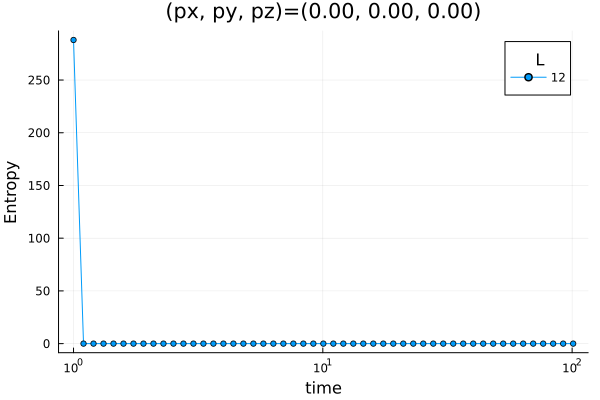

In [21]:
# Unwrap the main function to be run interactively

p_anyon = 0 # The change of applying an anyon of a given type vs a TC stabiliser!
p_tc = 1 - p_anyon
stab_distro_e = Categorical([p_tc/2, p_tc/2, p_anyon/2, p_anyon/2, 0, 0, 0, 0]) # In this case we condense e particles!
stab_distro_m = Categorical([p_tc/2, p_tc/2, 0, 0, p_anyon/2, p_anyon/2, 0, 0]) # In this case we condense m particles!
stab_distro_f = Categorical([p_tc/2, p_tc/2, 0, 0, 0, 0, p_anyon/2, p_anyon/2]) # In this case we condense f particles!
stab_distro = stab_distro_f

k = 3
L = 4*k  # linear system size
nt = Int(1e2)  # total number of time steps to evolve
nmeasure = 51 # number of measurements (log-spaced in time)

# For TEN: define the projection onto the ususal multipartitions of the torus
P_A = Diagonal(repeat(vcat(repeat([true], 8*k*k), repeat([false], 24*k*k)), 2))
P_B = Diagonal(repeat(vcat(repeat([false], 8*k*k), repeat([true], 8*k*k), repeat([false], 16*k*k)), 2))
P_C = Diagonal(repeat(vcat(repeat([false], 16*k*k), repeat([true], 8*k*k), repeat([false], 8*k*k)), 2))
P_D = Diagonal(repeat(vcat(repeat([false], 24*k*k), repeat([true], 8*k*k)), 2))
S = kron([false true; true false], Diagonal(repeat([true], 2*L*L)))


# times at which to measure stuff
measure_ts = exp10.(range(0, log10(nt+1), length=nmeasure))

number_of_experiments = 1
entropies_t = zeros(nmeasure, number_of_experiments)
Threads.@threads for exp_index  in 1:number_of_experiments

    # initial state is the maximally mixed state
    # since the package does not let you create an empty tableau, I defined the identity as the stabilizer, which is the same statement
    nbits = 2*L*L
    maximally_mixed_state = Stabilizer(zeros(UInt8, 1), # phases
                                    zeros(Bool, 1, nbits), # Z Tableau (as matrix of bool)
                                    zeros(Bool, 1, nbits) # X Tableau
                                    );

    # this is running the actual dynamics simulation (RENAME)
    entropy_t = run_measurement_only_dynamics_TEN!(MixedDestabilizer(maximally_mixed_state), # evolve this
                                            () -> toric_code(L, stab_distro),  # bind 
                                            nt,
                                            measure_ts)

    entropies_t[:, exp_index] = entropy_t

end


# plot entropy as function of time
p = plot(measure_ts, sum(entropies_t, dims=2)/number_of_experiments,
    title=format("(px, py, pz)=({:.2f}, {:.2f}, {:.2f})", 0, 0, 0),
    xlabel="time",
    ylabel="Entropy",
    marker=(:circle, 3),
    xscale=:log10,
    legendtitle="L",
    label=L)
# gui()  # this is the equivalent of matplotlibs show()
# Note: not needed since we are plotting in the cell (with added name to the plot "p")
display(p)